In [26]:
import cv2 as cv
import glob,shutil,os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from torchvision import transforms as tfs
from PIL import Image
import tensorflow as tf

In [28]:
'''
显示图片
输入：图片矩阵，画布大小：元组（宽，高）
'''
def showImg(img,figsize=(4,4),cmap = "gray"):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(img,cmap = cmap)
    plt.show()

In [29]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小
输入：input_dir：读取的文件夹，可使用模糊匹配,Rmap表示读取的形式，若为0则以灰度图形式读取
输出：图像列表，图片的路径列表
'''
def readImgAPath(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    if Rmap==0:
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in glob.glob(glob_dir)] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in glob.glob(glob_dir)] #通过通配符读取图像文件并且进行resize
    paths = [file for file in glob.glob(glob_dir)] #读取对应的路径
    # images = np.array(images)/255 #将一张图flatten之后归一化
    return images,paths

### 整理数据（每一个文件夹选取50张图片进行训练）

In [57]:
directory_name = "../result/character/"
# shutil.rmtree("./result/augment_img/")
for filename in os.listdir(directory_name):
    if(len(filename)==1):
#         print(directory_name+"/"+filename)
        paths = [path for path in glob.glob(directory_name+"/"+filename+"/*.png")[0:50] #正则匹配
#         print(paths)
        images = [cv.resize(cv.imread(path),(32,32)) for path in paths]
        names = [path.split(os.path.sep)[-1] for path in paths]
        file_aug = "./result/augment_img/"+filename
        is_exists = os.path.exists(file_aug)
        if not is_exists:
            os.makedirs(file_aug)
        for i,img in enumerate(images):
            name = names[i]
            cv.imwrite(file_aug+"/"+name,img)

### 数据增强

In [5]:
'''
读取文件夹下的所有文件及图片，以灰度图的形式读取并resize到指定大小
输入：input_dir：读取的文件夹，可使用模糊匹配,Rmap表示读取的形式，若为0则以灰度图形式读取
输出：图像列表，图片的标签,图片名称
'''
def readImgAPathAName(input_dir,imgsize=32,Rmap=0):
    glob_dir = input_dir + '*.png'
    paths = [path for path in glob.glob(glob_dir)]
    if (Rmap == 0):
        images = [cv.resize(cv.imread(file,0),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    else:
        images = [cv.resize(cv.imread(file),(imgsize,imgsize)) for file in paths] #通过通配符读取图像文件并且进行resize
    labels = [path.split(os.path.sep)[-2] for path in paths]
    names = [path.split(os.path.sep)[-1] for path in paths] #读取对应的名称
    # images = np.array(images)/255 #将一张图flatten之后归一化
    return images,labels,names

In [6]:
input_dir = "../result/augment_data/augment_img/?/"
images,labels,names = readImgAPathAName(input_dir)

In [7]:

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [8]:
len(images)

1800

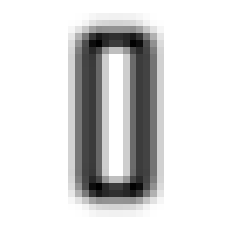

In [9]:
showImg(images[0])

In [1]:
plt.hist(images[0].ravel(),256,[0,256]) #ravel函数可以将其展平为一维数组，256表示条形bin的个数，【0，256】表示展示的统计范围
plt.show()

NameError: name 'plt' is not defined

In [20]:
def addNoise(image,max_std=10):
    std = tf.random.normal([1],0,max_std,seed=21)
    image_f = tf.cast(image,tf.float32)
    gs = std * tf.random.normal(tf.shape(image),seed=21)
    image_gauss = image_f+gs
    image_gauss = tf.maximum(image_gauss,0) #广播机制 返回（item，0）的最大值 即可限制最小值为0
    image_gauss = tf.minimum(image_gauss,255)
    image_gauss = tf.cast(image_gauss,tf.uint8)
    image_gauss = np.array(image_gauss)
    return image_gauss

In [24]:
'''
读取文件夹下所有图片，将其数据增强，二值化，膨胀
高斯核去掉噪音，然后使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img_augment(images,max_std = 10,kernel=3,iterations = 3):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        image_gauss = addNoise(img,max_std=max_std)
        #img=cv2.imread('F:cat.jpg',0)flag默认为1，即读取为彩色图像，如果要读取为灰度图（单通道），只需要把flag修改为为0即可。可直接读取灰度图
        ret,thImg = cv.threshold(image_gauss,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)  #修改THRESH_BINARY
        mask = cv.dilate(thImg,kernel=(3,3))
#         mask = cv.erode(mask,kernel=(kernel,kernel),iterations=iterations)
        Gimg_list.append(mask)
    return Gimg_list

### 增加噪声二值化及膨胀操作将训练数据集保存

In [30]:
# directory_name = "../result/character/"
directory_name = "../result/augment_data/augment_img"
shutil.rmtree("../result/augment_data/augment_mask_Gaussion/")
for filename in os.listdir(directory_name):
    paths = [path for path in glob.glob(directory_name+"/"+filename+"/*.png")] #正则匹配
    images = [cv.resize(cv.imread(path,0),(32,32)) for path in paths]
    names = [path.split(os.path.sep)[-1] for path in paths]
    file_aug = "../result/augment_data/augment_mask_Gaussion/"+filename
    is_exists = os.path.exists(file_aug)
    if not is_exists:
        os.makedirs(file_aug)
    Gimg_list = binary_img_augment(images,max_std=18,kernel=3,iterations=3)
    for i,img in enumerate(Gimg_list):
        name = names[i]
        cv.imwrite(file_aug+"/"+name,img)

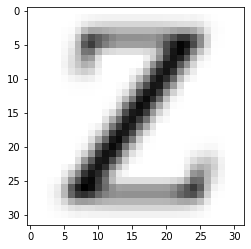

In [15]:
plt.imshow(images[20],cmap = "gray")

### 读取之后还需要二值化

In [250]:
'''
读取文件夹下所有图片，将其二值化
高斯核去掉噪音，然后使用OTSU算法二值化，再写入文件夹中
输入：需要处理的图像list
输出：二值化之后的图像list
'''
def binary_img(images):
    Gimg_list = []
    for i in range(len(images)):
        img = images[i]
        #img=cv2.imread('F:cat.jpg',0)flag默认为1，即读取为彩色图像，如果要读取为灰度图（单通道），只需要把flag修改为为0即可。可直接读取灰度图
        blur = cv.GaussianBlur(img,(5,5),0)
        ret,thImg = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)  #修改THRESH_BINARY
#         mask = cv.erode(thImg.astype('uint8'), kernel=np.ones((3,3)))
        Gimg_list.append(thImg)
        
    return Gimg_list

In [174]:
test_input_dir = "./result/temp_data/?/"
test_images,test_paths = readImgAPath(test_input_dir,32,0)  #读取进来的时候不是二值图的形式，可能在保存文件的时候出现了加权运算 有损 
#使用bmp文件保存才是无损的
test_labels = [item.split(os.path.sep)[-2] for item in test_paths]
# images_divert = [cv.bitwise_not(item) for item in test_images]  #反转图像黑白转换

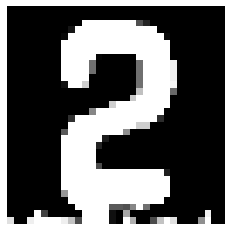

In [179]:
showImg(test_images[500])

In [186]:
Gtest_images = binary_img(test_images)

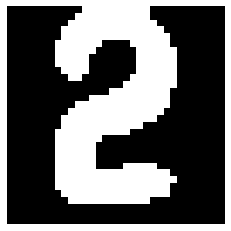

In [189]:
showImg(Gtest_images[480])